# EfficientNetB4 ile Transfer Learning Tabanlı Görüntü Sınıflandırma

Bu notebook’ta EfficientNetB4 mimarisi kullanılarak Transfer Learning
yaklaşımıyla bir görüntü sınıflandırma modeli eğitilmiş ve
test veri seti üzerinde detaylı performans analizi yapılmıştır.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.efficientnet import EfficientNetB4, preprocess_input
from tensorflow.keras.preprocessing import image_dataset_from_directory

from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, matthews_corrcoef,
    precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc
)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from itertools import cycle

## 1. Veri Seti ve Ön İşleme (Data Augmentation)

Veri seti eğitim (train), doğrulama (validation) ve test olmak üzere
üç alt kümeye ayrılmıştır.

Eğitim verisi üzerinde:
- Yatay ve dikey çevirme
- Rastgele döndürme
- Rastgele yakınlaştırma
- Kontrast artırma

işlemleri uygulanarak modelin genelleme yeteneği güçlendirilmiştir.
Tüm görüntüler EfficientNet mimarisine uygun şekilde normalize edilmiştir.


In [ ]:
# ---- CONFIG ----
IMG_SIZE = (380, 380)
BATCH_SIZE = 16
EPOCHS = 30
LEARNING_RATE = 1e-4
NUM_CLASSES = 5

TRAIN_DIR = "/content/drive/MyDrive/Sugarcane Disease/dataset_split/train"
VAL_DIR   = "/content/drive/MyDrive/Sugarcane Disease/dataset_split/val"
TEST_DIR  = "/content/drive/MyDrive/Sugarcane Disease/dataset_split/test"

OUTPUT_DIR = "/content/drive/MyDrive/EfficientNetB4_Results_Update"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ---- DATA AUGMENTATION ----
train_augment = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomFlip("vertical"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2)
])

train_ds = image_dataset_from_directory(TRAIN_DIR, image_size=IMG_SIZE,
                                        batch_size=BATCH_SIZE, shuffle=True)
val_ds   = image_dataset_from_directory(VAL_DIR, image_size=IMG_SIZE,
                                        batch_size=BATCH_SIZE, shuffle=False)
test_ds  = image_dataset_from_directory(TEST_DIR, image_size=IMG_SIZE,
                                        batch_size=BATCH_SIZE, shuffle=False)

class_names = train_ds.class_names

def preprocess(images, labels):
    images = train_augment(images)
    return preprocess_input(images), labels

train_ds = train_ds.map(preprocess)
val_ds   = val_ds.map(lambda x, y: (preprocess_input(x), y))
test_ds  = test_ds.map(lambda x, y: (preprocess_input(x), y))

## 2. Model Mimarisi ve Fine-Tuning (EfficientNetB4)

Bu çalışmada ImageNet üzerinde önceden eğitilmiş EfficientNetB4 modeli
kullanılmıştır.

Modelin üst katmanları fine-tuning yaklaşımı ile yeniden eğitilmiştir.
Son katmanlara yakın **120 katman eğitime açılarak**, modelin
veri setine daha iyi uyum sağlaması hedeflenmiştir.


In [ ]:
# ---- MODEL ----
base_model = EfficientNetB4(include_top=False, weights="imagenet",
                            input_shape=(380, 380, 3))
base_model.trainable = True

fine_tune_at = len(base_model.layers) - 120
for i, layer in enumerate(base_model.layers):
    layer.trainable = (i >= fine_tune_at)

model = keras.Sequential([
    layers.Input(shape=(380, 380, 3)),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.1),
    layers.Dense(NUM_CLASSES, activation="softmax")
])

model.compile(
    optimizer=keras.optimizers.Adam(LEARNING_RATE),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=4,
                                      factor=0.5, min_lr=1e-6),
    keras.callbacks.ModelCheckpoint(f"{OUTPUT_DIR}/best_model.h5",
                                    monitor="val_accuracy",
                                    save_best_only=True),
    keras.callbacks.CSVLogger(f"{OUTPUT_DIR}/train_log.csv")
]

## 3. Modelin Eğitimi

Model, belirlenen epoch sayısı boyunca eğitim ve doğrulama veri setleri
kullanılarak eğitilmiştir.

ReduceLROnPlateau yöntemi ile doğrulama kaybı iyileşmediğinde
öğrenme oranı düşürülmüş ve en iyi model doğruluk değerine göre
kaydedilmiştir.


In [ ]:
# ---- TRAIN ----
history = model.fit(train_ds, validation_data=val_ds,
                    epochs=EPOCHS, callbacks=callbacks)

# ---- SAVE (TAM MODEL + AĞIRLIK DOSYASI) ----
model.save(f"{OUTPUT_DIR}/final_model.h5")  # Tam model
model.save_weights(f"{OUTPUT_DIR}/efficientNetB4_final_model.weights.h5")  # Streamlit için gerekli ağırlık

## 4. Eğitim ve Doğrulama Doğrulukları (Accuracy)


In [ ]:
# ---- PLOTS ----
plt.figure(figsize=(8,5))
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.legend(); plt.title("Accuracy"); plt.grid()
plt.savefig(f"{OUTPUT_DIR}/accuracy_plot.png")

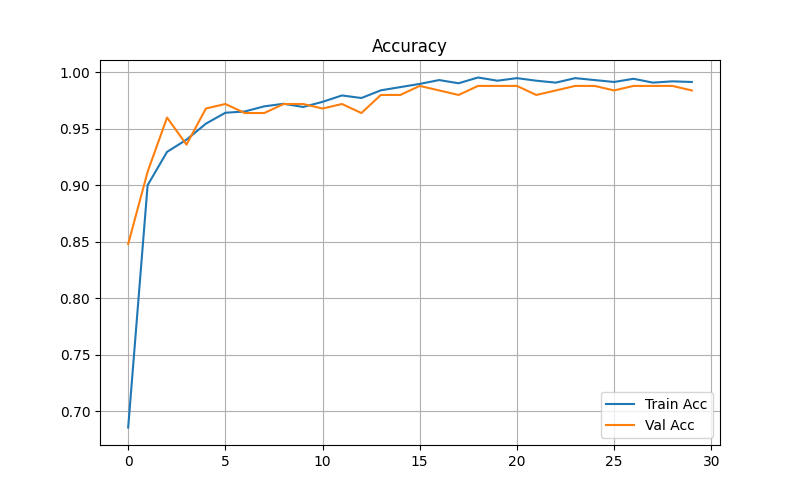

Grafik incelendiğinde:
- Eğitim doğruluğunun %99 seviyelerine ulaştığı,
- Doğrulama doğruluğunun eğitim doğruluğuna çok yakın seyrettiği
görülmektedir.

Bu durum, modelin hem güçlü öğrenme hem de
yüksek genelleme başarısı sergilediğini göstermektedir.


## 5. Eğitim ve Doğrulama Kayıp Değerleri (Loss)


In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend(); plt.title("Loss"); plt.grid()
plt.savefig(f"{OUTPUT_DIR}/loss_plot.png")

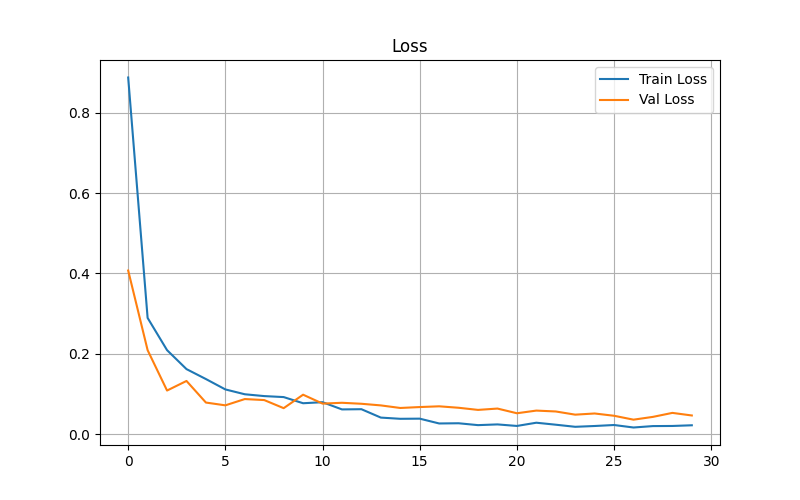

Eğitim ve doğrulama kayıplarının hızlı ve istikrarlı biçimde
azaldığı görülmektedir.

Doğrulama kaybının düşük seviyelerde seyretmesi,
modelin aşırı öğrenme göstermediğini ortaya koymaktadır.


## 6. Test Veri Seti Üzerinde Performans Metrikleri

Modelin test veri seti üzerindeki performansı aşağıdaki
metrikler kullanılarak değerlendirilmiştir:
- Accuracy
- Balanced Accuracy
- Matthews Correlation Coefficient (MCC)
- Precision
- Recall
- F1 Score


In [ ]:

# ---- EVALUATION ----
y_true, y_pred, y_prob = [], [], []

for x, y in test_ds:
    p = model.predict(x)
    y_prob.extend(p)
    y_pred.extend(np.argmax(p, axis=1))
    y_true.extend(y.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

acc  = accuracy_score(y_true, y_pred)
bacc = balanced_accuracy_score(y_true, y_pred)
mcc  = matthews_corrcoef(y_true, y_pred)
prec = precision_score(y_true, y_pred, average="macro")
rec  = recall_score(y_true, y_pred, average="macro")
f1   = f1_score(y_true, y_pred, average="macro")

with open(f"{OUTPUT_DIR}/metrics_report.txt", "w") as f:
    f.write(f"Accuracy: {acc}\nBalanced Accuracy: {bacc}\nMCC: {mcc}\nPrecision: {prec}\nRecall: {rec}\nF1 Score: {f1}\n")
    f.write(classification_report(y_true, y_pred, target_names=class_names))



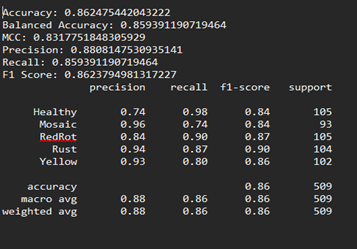

Elde edilen sonuçlar, modelin sınıflar arasında
oldukça dengeli ve yüksek doğrulukta
bir sınıflandırma performansı sunduğunu göstermektedir.


## 7. Test Veri Seti Karmaşıklık Matrisi (Confusion Matrix)


In [ ]:
# ---- CONFUSION MATRIX ----
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.savefig(f"{OUTPUT_DIR}/confusion_matrix.png")

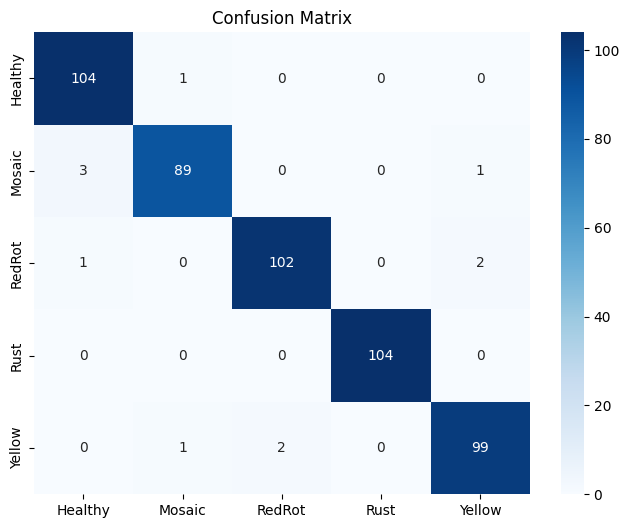

Karmaşıklık matrisi incelendiğinde,
tüm sınıflarda çok yüksek doğru sınıflandırma oranları elde edilmiştir.

Özellikle Rust sınıfında hatasız sınıflandırma yapılması,
modelin ayırt edici gücünün yüksek olduğunu göstermektedir.


## 8. ROC Eğrisi ve ROC AUC Analizi


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 1762 files belonging to 5 classes.
Found 250 files belonging to 5 classes.
Found 509 files belonging to 5 classes.
71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb4 (Functional)     │ (None, 12, 12, 1792)   │    17,673,823 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1792)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1792)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       459,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,134,116 (69.18 MB)

 Trainable params: 12,248,785 (46.73 MB)

 Non-trainable params: 5,885,331 (22.45 MB)

Epoch 1/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5228 - loss: 1.2171

111/111 ━━━━━━━━━━━━━━━━━━━━ 428s 3s/step - accuracy: 0.5242 - loss: 1.2142 - val_accuracy: 0.8480 - val_loss: 0.4073 - learning_rate: 1.0000e-04
Epoch 2/30
110/111 ━━━━━━━━━━━━━━━━━━━━ 0s 768ms/step - accuracy: 0.8903 - loss: 0.3250

111/111 ━━━━━━━━━━━━━━━━━━━━ 91s 815ms/step - accuracy: 0.8904 - loss: 0.3244 - val_accuracy: 0.9120 - val_loss: 0.2090 - learning_rate: 1.0000e-04
Epoch 3/30
110/111 ━━━━━━━━━━━━━━━━━━━━ 0s 814ms/step - accuracy: 0.9159 - loss: 0.2219

111/111 ━━━━━━━━━━━━━━━━━━━━ 97s 857ms/step - accuracy: 0.9162 - loss: 0.2216 - val_accuracy: 0.9600 - val_loss: 0.1085 - learning_rate: 1.0000e-04
Epoch 4/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 132s 782ms/step - accuracy: 0.9331 - loss: 0.1717 - val_accuracy: 0.9360 - val_loss: 0.1324 - learning_rate: 1.0000e-04
Epoch 5/30
110/111 ━━━━━━━━━━━━━━━━━━━━ 0s 766ms/step - accuracy: 0.9462 - loss: 0.1585

111/111 ━━━━━━━━━━━━━━━━━━━━ 91s 808ms/step - accuracy: 0.9463 - loss: 0.1581 - val_accuracy: 0.9680 - val_loss: 0.0786 - learning_rate: 1.0000e-04
Epoch 6/30
110/111 ━━━━━━━━━━━━━━━━━━━━ 0s 805ms/step - accuracy: 0.9575 - loss: 0.1265

111/111 ━━━━━━━━━━━━━━━━━━━━ 95s 850ms/step - accuracy: 0.9577 - loss: 0.1262 - val_accuracy: 0.9720 - val_loss: 0.0717 - learning_rate: 1.0000e-04
Epoch 7/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 91s 814ms/step - accuracy: 0.9614 - loss: 0.1103 - val_accuracy: 0.9640 - val_loss: 0.0873 - learning_rate: 1.0000e-04
Epoch 8/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 89s 795ms/step - accuracy: 0.9659 - loss: 0.1011 - val_accuracy: 0.9640 - val_loss: 0.0848 - learning_rate: 1.0000e-04
Epoch 9/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 89s 794ms/step - accuracy: 0.9703 - loss: 0.0954 - val_accuracy: 0.9720 - val_loss: 0.0646 - learning_rate: 1.0000e-04
Epoch 10/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 91s 813ms/step - accuracy: 0.9707 - loss: 0.0840 - val_accuracy: 0.9720 - val_loss: 0.0982 - learning_rate: 1.0000e-04
Epoch 11/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 140s 796ms/step - accuracy: 0.9743 - loss: 0.0771 - val_accuracy: 0.9680 - val_loss: 0.0760 - learning_rate: 1.0000e-04
Epoch 12/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 141s 789ms/st

111/111 ━━━━━━━━━━━━━━━━━━━━ 91s 817ms/step - accuracy: 0.9769 - loss: 0.0491 - val_accuracy: 0.9800 - val_loss: 0.0715 - learning_rate: 5.0000e-05
Epoch 15/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 92s 827ms/step - accuracy: 0.9873 - loss: 0.0415 - val_accuracy: 0.9800 - val_loss: 0.0651 - learning_rate: 5.0000e-05
Epoch 16/30
110/111 ━━━━━━━━━━━━━━━━━━━━ 0s 762ms/step - accuracy: 0.9895 - loss: 0.0407

111/111 ━━━━━━━━━━━━━━━━━━━━ 90s 806ms/step - accuracy: 0.9896 - loss: 0.0406 - val_accuracy: 0.9880 - val_loss: 0.0674 - learning_rate: 5.0000e-05
Epoch 17/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 92s 820ms/step - accuracy: 0.9948 - loss: 0.0275 - val_accuracy: 0.9840 - val_loss: 0.0693 - learning_rate: 5.0000e-05
Epoch 18/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 88s 782ms/step - accuracy: 0.9879 - loss: 0.0290 - val_accuracy: 0.9800 - val_loss: 0.0656 - learning_rate: 2.5000e-05
Epoch 19/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 88s 788ms/step - accuracy: 0.9934 - loss: 0.0276 - val_accuracy: 0.9880 - val_loss: 0.0603 - learning_rate: 2.5000e-05
Epoch 20/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 87s 776ms/step - accuracy: 0.9927 - loss: 0.0231 - val_accuracy: 0.9880 - val_loss: 0.0637 - learning_rate: 2.5000e-05
Epoch 21/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 87s 782ms/step - accuracy: 0.9947 - loss: 0.0182 - val_accuracy: 0.9880 - val_loss: 0.0520 - learning_rate: 2.5000e-05
Epoch 22/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 86s 775ms/s

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

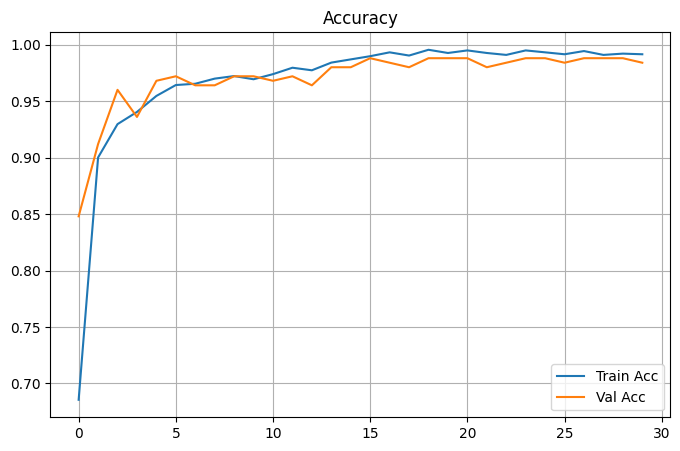

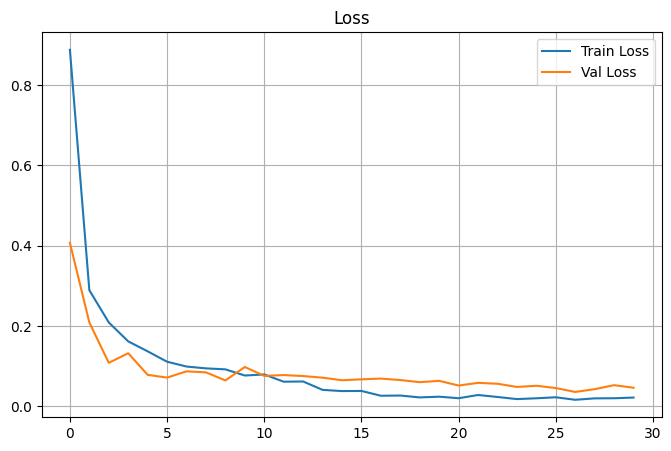

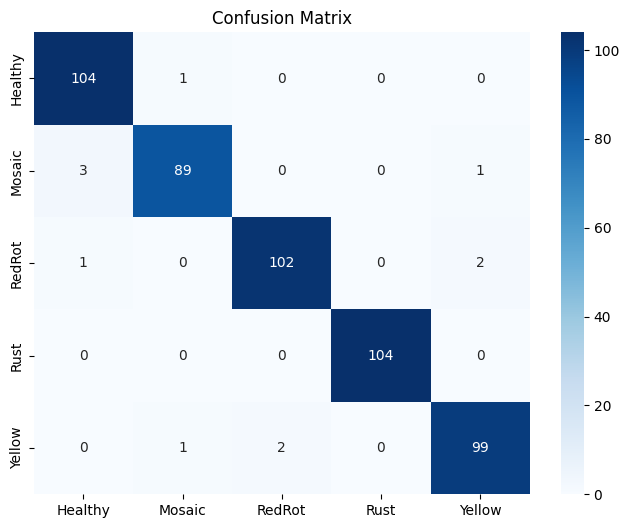

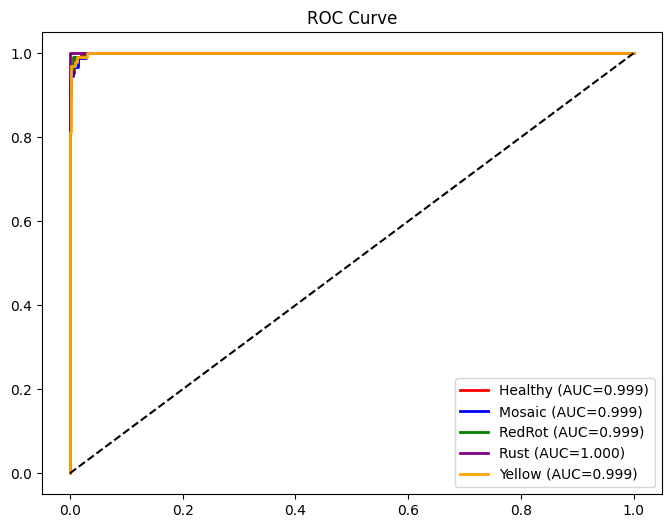

In [ ]:
# ---- ROC CURVE ----
y_true_bin = tf.keras.utils.to_categorical(y_true, NUM_CLASSES)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8,6))
colors = cycle(["red", "blue", "green", "purple", "orange"])
for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f"{class_names[i]} (AUC={roc_auc[i]:.3f})", color=color)

plt.plot([0,1],[0,1],"k--")
plt.legend()
plt.title("ROC Curve")
plt.savefig(f"{OUTPUT_DIR}/roc_curve.png")


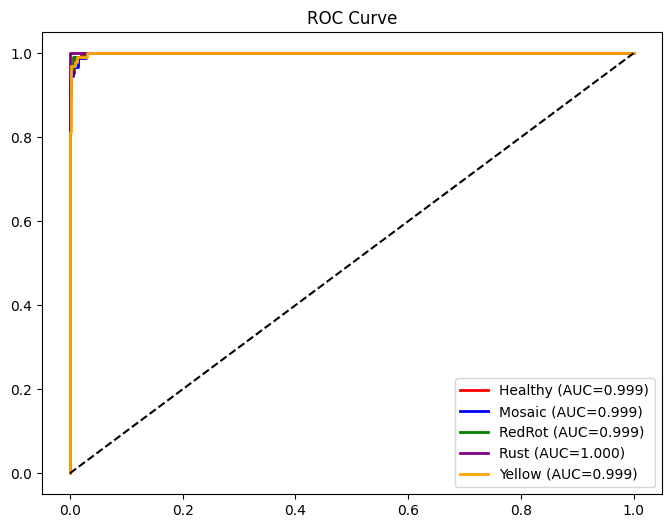

ROC eğrileri incelendiğinde,
tüm sınıflar için ROC AUC değerlerinin
0.99 ve üzeri olduğu görülmektedir.

Bu durum, EfficientNetB4 modelinin
sınıflar arası ayırt ediciliğinin son derece yüksek olduğunu göstermektedir.


## 9. Genel Değerlendirme

EfficientNetB4 tabanlı Transfer Learning modeli,
test veri seti üzerinde çok yüksek doğruluk,
dengeli sınıflandırma ve güçlü genelleme performansı sergilemiştir.